In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
import streamlit as st
import json

In [32]:

train_data_dir = 'C:\\Users\\Motka\\Desktop\\bird_classification\\dataset\\train'
validation_data_dir = 'C:\\Users\\Motka\\Desktop\\bird_classification\\dataset\\validation'
model_save_path = 'C:\\Users\\Motka\\Desktop\\bird_classification\\models\\bird_classification_model.keras'
class_names_path = 'C:\\Users\\Motka\\Desktop\\bird_classification\\models\\class_names.json'


train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


class_names = sorted(train_generator.class_indices.keys())
print("Названия классов:", class_names)


Found 11788 images belonging to 200 classes.
Found 11788 images belonging to 200 classes.
Названия классов: ['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_

In [26]:
# Загрузка предобученной модели VGG16 без верхнего уровня (головы)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Заморозка слоев базовой модели
for layer in base_model.layers:
    layer.trainable = False

# Добавление собственных слоев поверх базовой модели
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Создание модели
model = Model(inputs=base_model.input, outputs=predictions)

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [27]:

checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)




Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 1346s 4s/step - accuracy: 0.0079 - loss: 5.3174 - val_accuracy: 0.0310 - val_loss: 4.9628
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 1350s 4s/step - accuracy: 0.0235 - loss: 4.9696 - val_accuracy: 0.0610 - val_loss: 4.6288
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 1362s 4s/step - accuracy: 0.0373 - loss: 4.7399 - val_accuracy: 0.0825 - val_loss: 4.4180
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 1362s 4s/step - accuracy: 0.0475 - loss: 4.5778 - val_accuracy: 0.1017 - val_loss: 4.2247
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 1363s 4s/step - accuracy: 0.0533 - loss: 4.4596 - val_accuracy: 0.1165 - val_loss: 4.1028
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 1361s 4s/step - accuracy: 0.0751 - loss: 4.3446 - val_accuracy: 0.1382 - val_loss: 3.9444
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 1363s 4s/step - accuracy: 0.0826 - loss: 4.2411 - val_accuracy: 0.1586 - val_loss: 3.8454
Epoch 8/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 1362s 4s/step - accuracy: 0.0942 - loss: 4.1367 - 

KeyboardInterrupt: 

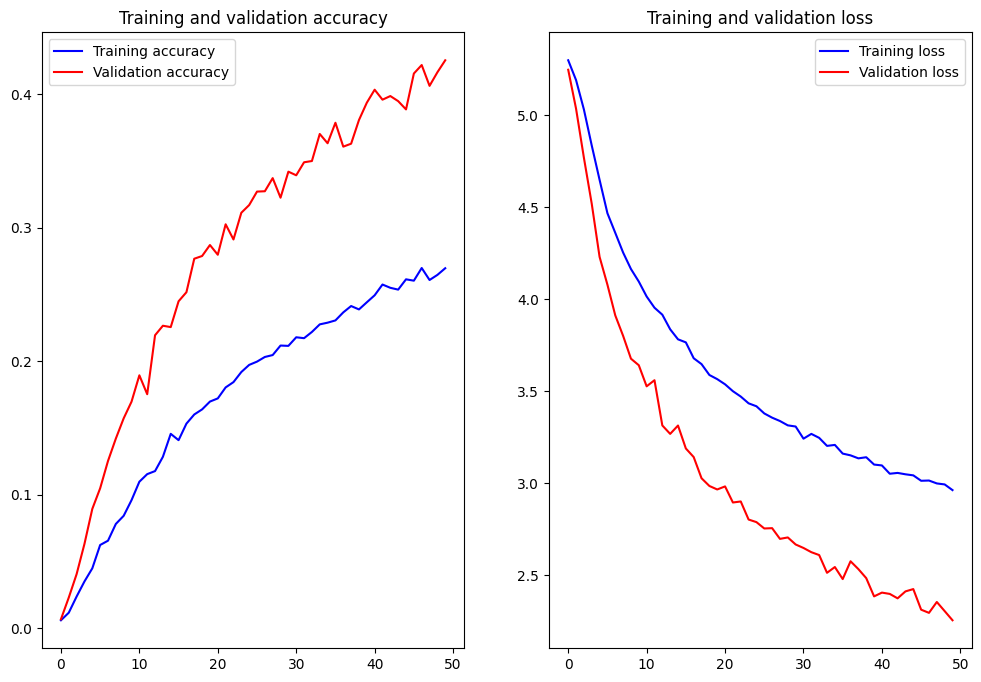

In [39]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



In [38]:

class_names = sorted(train_generator.class_indices.keys())
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)


model.save('C:\\Users\\Motka\\Desktop\\bird_classification\\models\\bird_classification_model.keras')


loaded_model = tf.keras.models.load_model('C:\\Users\\Motka\\Desktop\\bird_classification\\models\\bird_classification_model.keras')
